# CBE 162-Fall 2024 Lab 4: Laplace Transforms in Python
Outline:
* Laplace transforms in Python using signal




## Imports

In [1]:


# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, signal

## Example: First order system
Consider a general first-order system described by the following ODE
$$\tau_p \frac{dy}{dt} = -y + K_p u,$$
where $u$ is the input and $y$ is the output. The parameters $K_p$ and $\tau_p$ are given below:


In [2]:
Kp = 3
taup = 2
y0 = 0

(i)We will  Solve the ODE to obtain a plot of $y$ vs. time, assuming that the input is a step change from $0$ to $3$ and that $y(0) = 0$. Simulate the ODE from $t=0$ to $t=20$. What is the new steady-state value of $y$ after the change?

In [3]:
u= [0, 1, 2, 3]
u_times = np.array([0, 5, 10, 15])

def ode(t,  y, Kp, taup, u):
    u_val = u[0]
    for i in range(len(u_times) - 1):
        if t >= u_times[i+1]:
            u_val = u[i+1]
    dydt = (1/taup) * (Kp*u_val - y)
    return dydt
     
t = np.linspace(0, 20, 1000)
y = np.linspace(0, 20, 1000)

solve = integrate.odeint(ode, y0, t, args = (Kp, taup, u))


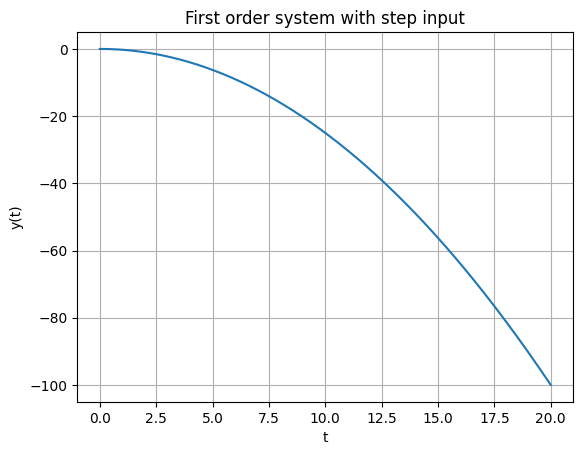

New steady-state y is: 9


In [4]:
plt.plot(t, solve)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('First order system with step input')
plt.grid(True)
plt.show()

steady_state_value = Kp * u[3]
print("New steady-state y is:", steady_state_value)

Obtain the Laplace transform in terms of deviation variables.

(ii) Using the ``scipy.signal.TransferFunction`` function, create a transfer function for this system. You can find the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.TransferFunction.html).

In [5]:
# Define numerator and denominator polynomials
num = [Kp]
den = [taup, 1]

# Define transfer function
TF_y_u = signal.TransferFunction(num, den)

# Print
print(TF_y_u)

TransferFunctionContinuous(
array([1.5]),
array([1. , 0.5]),
dt: None
)


(iii) Assuming the same step input change (i.e., from $0$ to $3$), use the ``step`` function in ``scipy.signal.step`` to plot $y$ vs. time. On the same graph, plot the solution of $y$ vs. time given by the solution to the ODE.

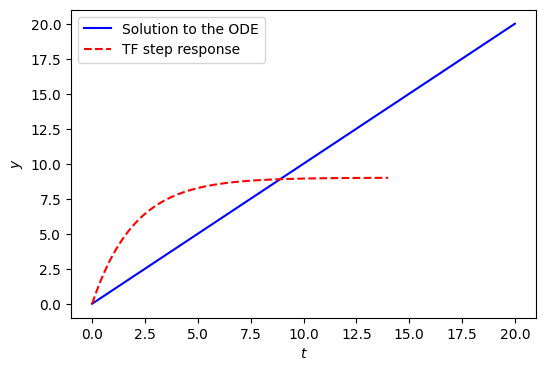

In [6]:
# Using signal.step will yield the step response for a UNIT change in the input
tStepResp, yUnitStepResp = signal.step(TF_y_u)
# Need to multiply the response by the magnitude of the step change
stepChange = 3-0
yStepResp = stepChange*yUnitStepResp

plt.figure(dpi=100, figsize = (6,4))
plt.plot(t, y, 'b-', label = 'Solution to the ODE')
plt.plot(tStepResp, yStepResp, 'r--', label = 'TF step response')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend()
plt.show()

# Problem 1:
Consider a Jacket cooled reactor. The reactor has a diameter $D$ and Height $H$. The jacket is a homogenous annulus with a height of 75% of the height of the cylindrical reactor, and thickness $w$.The reactor has an inlet and outlet flow rate $F$. The inlet water comes in at $T_{in}$.  The fluid in the jacket as well as the reactor is water. The jacket outlet temperature  is  $T_{j,ss}$, and Jacket inlet temperature is $T_{j,in}$. The reactor fluid is at $T_{ss}$ before t=0, and at steady state. The heat transfer coefficient for the reactor wall is $U$.Find the flow rate of water through the jacket at steady state. Write an energy balance in the jacket as well as the reactor, and frame differential equations for $T$ and $T_j$. Obtain the transfer functions of $T$ against $T_j$, and of $T_j$ against jacket  flow rate. Now, a step input is given to the jacket such that the flow rate of water increases by 15% at t=0. Use scipy.signal.step to plot  $T$ and $T_j$  against time, until t=1000s.Verify your results with a numerical solver.

In [27]:
D=1.5#m
H=3 #m
F=40 #lit/s
w=0.1 #m
Tin=60 #C
Tjss=20 #C
Tjin=18 #C
Tss=55.1 #C/
U=2211.95# W/m2 K
rho=1000 #kg/m3
Cp=4200 #J/kg K




Consider the following linearization for the differential equation:

# $\frac{dT_j}{dt}=\frac{T_{jin}F_j(t)}{V_j}-\frac{T_{jss}F_j(t)}{V_j}-\frac{F_{j,new}T_j(t)}{V_j}+\frac{UA_s}{ρC_pV_j}[T(t)-T_j(t)]$

where $V_j$ is the jacket volume. You can solve for $\frac{dT}{dt}$ using energy balance. It requires no linearization. Obtain a transfer function of $\frac{T(s)}{T_j(s)}$ and solve to get the dynamic behaviour for the system.

In [30]:
F_j = F 
V = (np.pi * D**2 * H) / 4
Vj = ((np.pi * (D + w)**2 * H * 0.75) / 4) - V
As = np.pi * D * H

def jacket_flow(t):
    if t <= 0:
        return F_j
    else:
        return 1.15*F_j
    
def energy_balance(T_vals, t, F, U, As, V, Vj, Tin, Tjin, Tss, Tjss):
    T, Tj = T_vals
    Fj = jacket_flow(t)
    dTdt = (F * rho * Cp * (Tin - T) + U * As * (Tj - T)) / (rho * V * Cp)
    dTjdt = (Fj * rho * Cp * (Tjin - Tj) + U * As * (T - Tj)) / (rho * Vj * Cp)
    return [dTdt, dTjdt]

t = np.linspace(-50, 1000, 1000)    
initial_conditions = [Tss, Tjss]
T_vals = integrate.odeint(energy_balance, initial_conditions, t, args=(F, U, As, V, Vj, Tin, Tjin, Tss, Tjss))

T = T_vals[:, 0]
Tj = T_vals[:, 1]


/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_1445/3515558056.py:16: RuntimeWarning: overflow encountered in scalar multiply
  dTjdt = (Fj * rho * Cp * (Tjin - Tj) + U * As * (T - Tj)) / (rho * Vj * Cp)
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_1445/3515558056.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  dTdt = (F * rho * Cp * (Tin - T) + U * As * (Tj - T)) / (rho * V * Cp)
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_1445/3515558056.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  dTjdt = (Fj * rho * Cp * (Tjin - Tj) + U * As * (T - Tj)) / (rho * Vj * Cp)


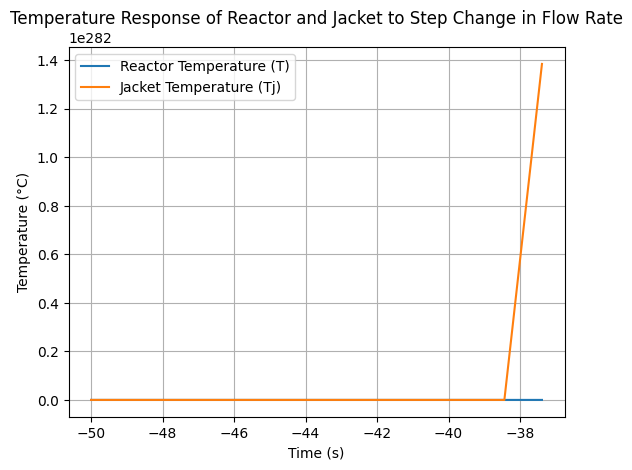

In [31]:
plt.plot(t, T, label="Reactor Temperature (T)")
plt.plot(t, Tj, label="Jacket Temperature (Tj)")
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Response of Reactor and Jacket to Step Change in Flow Rate')
plt.legend()
plt.grid(True)
plt.show()